In [1]:
import numpy as np
import pandas as pd
import os
import glob
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import re
from pathlib import Path
import matplotlib.colors as mcolors
from collections import defaultdict
from scipy.stats import f_oneway
from itertools import combinations
from pyts.datasets import load_gunpoint
from pyts.image import RecurrencePlot
from pyts.image import GramianAngularField
from pyts.image import MarkovTransitionField

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

## Torchvision
import torchvision
from torchvision.datasets import STL10
from torchvision import transforms
# PyTorch Lightning
import pytorch_lightning as pl

from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint



In [3]:
current_directory_path = Path.cwd()
current_directory_path

PosixPath('/home/hyang/Documents/SimCLR')

In [4]:
directory = current_directory_path.parent /'activity_resistance_ML' / 'processed' 
directory

PosixPath('/home/hyang/Documents/activity_resistance_ML/processed')

In [5]:
data_loc = sorted(directory.glob('20240917_5-6-8-9-12_CO_100ppm_25_processed.xlsx'))
data_loc

[PosixPath('/home/hyang/Documents/activity_resistance_ML/processed/20240917_5-6-8-9-12_CO_100ppm_25_processed.xlsx')]

In [70]:
data_loc2 = sorted(directory.glob('20240719_*120_processed.xlsx'))
data_loc2

[PosixPath('/home/hyang/Documents/activity_resistance_ML/processed/20240719_1-2-9-10-12_CO_25ppm_120_processed.xlsx')]

In [101]:
data_loc2[0].name

'20240719_1-2-9-10-12_CO_25ppm_120_processed.xlsx'

In [95]:
e = data_loc2[0].name.split('.')[0].split('_')
e

['20240719', '1-2-9-10-12', 'CO', '25ppm', '120', 'processed']

In [98]:
e[1] = 'MLmx9-1'
'_'.join(e[:-1])

'20240719_MLmx9-1_CO_25ppm_120'

In [99]:
ex = '_'.join(e[:-1]) + '.jpg'
path_to_save = current_directory_path / ex
path_to_save

PosixPath('/home/hyang/Documents/SimCLR/20240719_MLmx9-1_CO_25ppm_120.jpg')

In [6]:
df = pd.read_excel(data_loc[0], sheet_name = 'sensitivity')
df.head()

,Unnamed: 0,Time,Elapsed,ML5-1,ML5-2,ML5-3,ML5-4,ML5-5,ML5-6,ML5-7,...,ML9-5,ML9-6,ML9-7,ML9-8,ML12-1,ML12-2,ML12-3,ML12-4,Timestamp,elapsed_time
0,0,9/17/2024 14:13:40:661,00:21:26:34:378,-1.426377e-07,3.403706e-06,0.000002,0.000006,0.000034,0.000037,-0.000012,...,0.000184,0.000229,0.000192,0.000196,0.000081,0.000156,0.000087,0.000121,2024-09-17 14:13:40.661,6552.863
1,1,9/17/2024 14:13:44:110,00:21:26:37:827,1.012288e-05,-1.329627e-05,-0.000009,0.000018,0.000080,0.000057,0.000084,...,0.000172,0.000244,0.000223,0.000142,0.000132,0.000163,0.000100,0.000136,2024-09-17 14:13:44.110,6556.312
2,2,9/17/2024 14:13:47:559,00:21:26:41:276,2.293825e-05,-1.051533e-05,-0.000031,0.000006,-0.000018,0.000020,-0.000091,...,0.000149,0.000124,0.000180,0.000133,0.000138,0.000150,0.000063,0.000144,2024-09-17 14:13:47.559,6559.761
3,3,9/17/2024 14:13:51:08,00:21:26:44:725,1.909364e-05,-9.124862e-06,-0.000006,0.000018,0.000052,0.000050,0.000029,...,0.000207,0.000146,0.000176,0.000193,0.000160,0.000158,0.000075,0.000124,2024-09-17 14:13:51.080,6563.282
4,4,9/17/2024 14:13:54:458,00:21:26:48:175,2.165672e-05,6.227651e-07,-0.000015,0.000020,-0.000018,0.000049,0.000052,...,0.000186,0.000171,0.000238,0.000172,0.000172,0.000183,0.000081,0.000127,2024-09-17 14:13:54.458,6566.660


In [7]:
df['time_diff'] = df['elapsed_time'].diff()

<Axes: xlabel='elapsed_time', ylabel='time_diff'>

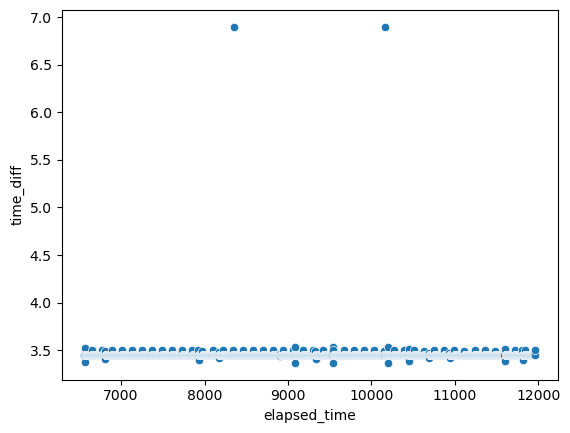

In [9]:
sns.scatterplot(data = df, x = 'elapsed_time', y = 'time_diff')

In [10]:
large_diff_rows = df[df['time_diff'] > 6.5] # large_diff_rows = df[df['time_diff'] > 10]

time_cut = large_diff_rows['elapsed_time'].to_list()

In [11]:
large_diff_rows

,Unnamed: 0,Time,Elapsed,ML5-1,ML5-2,ML5-3,ML5-4,ML5-5,ML5-6,ML5-7,...,ML9-6,ML9-7,ML9-8,ML12-1,ML12-2,ML12-3,ML12-4,Timestamp,elapsed_time,time_diff
522,522,9/17/2024 14:43:45:360,00:21:56:39:077,0.000018,-0.000017,0.000046,-0.000017,-0.000082,0.000074,0.000214,...,0.000299,0.000120,0.000207,0.000200,0.000101,0.000122,0.000128,2024-09-17 14:43:45.360,8357.562,6.898
1044,1044,9/17/2024 15:13:50:066,00:22:26:43:783,0.000011,0.000039,0.000032,0.000023,0.000081,0.000136,0.000133,...,0.000221,0.000042,0.000127,-0.000045,0.000162,0.000171,0.000152,2024-09-17 15:13:50.066,10162.268,6.898


In [113]:
data_loc2[0]

PosixPath('/home/hyang/Documents/activity_resistance_ML/processed/20240719_1-2-9-10-12_CO_25ppm_120_processed.xlsx')

In [71]:
df1 = pd.read_excel(data_loc2[0], sheet_name = 'sensitivity')
df1.head()

,Unnamed: 0,Time,Elapsed,ML1-1,ML1-2,ML1-3,ML1-4,ML1-5,ML1-6,ML1-7,...,ML10-5,ML10-6,ML10-7,ML10-8,ML12-1,ML12-2,ML12-3,ML12-4,Timestamp,elapsed_time
0,0,7/19/2024 14:17:36:645,00:00:16:42:365,0.000546,0.000561,0.00046,0.000417,0.000577,0.000591,0.000664,...,0.001394,0.001502,0.001414,0.001133,0.000801,0.001294,0.000988,0.000762,2024-07-19 14:17:36.645,1002.365
1,1,7/19/2024 14:17:38:944,00:00:16:44:664,0.000526,0.000561,0.00044,0.000403,0.000577,0.000602,0.000650,...,0.001408,0.001469,0.001402,0.001022,0.000774,0.001253,0.001019,0.000749,2024-07-19 14:17:38.944,1004.664
2,2,7/19/2024 14:17:41:242,00:00:16:46:962,0.000541,0.000532,0.00044,0.000396,0.000569,0.000612,0.000664,...,0.001412,0.001458,0.001353,0.001036,0.000747,0.001212,0.000981,0.000737,2024-07-19 14:17:41.242,1006.962
3,3,7/19/2024 14:17:43:541,00:00:16:49:261,0.000511,0.000504,0.00045,0.000396,0.000545,0.000591,0.000650,...,0.001376,0.001436,0.001341,0.001115,0.000795,0.001146,0.000965,0.000762,2024-07-19 14:17:43.541,1009.261
4,4,7/19/2024 14:17:45:840,00:00:16:51:560,0.000536,0.000509,0.00045,0.000396,0.000529,0.000591,0.000635,...,0.001340,0.001441,0.001316,0.001018,0.000801,0.001162,0.000950,0.000749,2024-07-19 14:17:45.840,1011.560


<Axes: xlabel='elapsed_time', ylabel='ML1-1'>

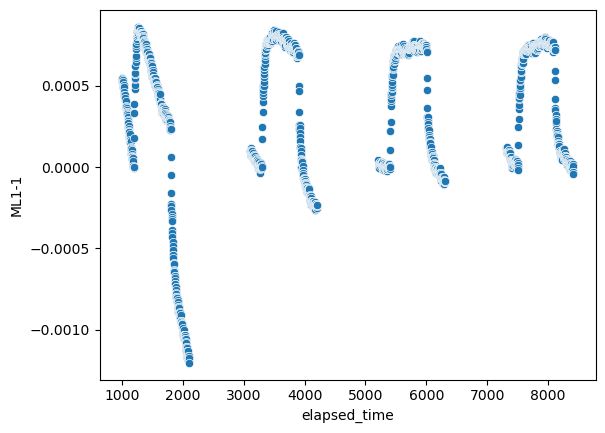

In [72]:
sns.scatterplot(data = df1, x = 'elapsed_time', y= 'ML1-1')

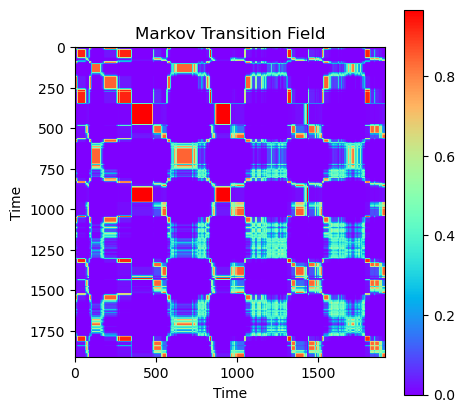

array([[0.8436214, 0.8436214, 0.8436214, ..., 0.       , 0.       ,
        0.       ],
       [0.8436214, 0.8436214, 0.8436214, ..., 0.       , 0.       ,
        0.       ],
       [0.8436214, 0.8436214, 0.8436214, ..., 0.       , 0.       ,
        0.       ],
       ...,
       [0.       , 0.       , 0.       , ..., 0.8495935, 0.8495935,
        0.8495935],
       [0.       , 0.       , 0.       , ..., 0.8495935, 0.8495935,
        0.8495935],
       [0.       , 0.       , 0.       , ..., 0.8495935, 0.8495935,
        0.8495935]])

In [104]:

df1_subset = np.array(df1['ML1-1'].to_list())
draw_mtf(df1_subset)

In [107]:
df1['time_diff'] = df1['elapsed_time'].diff()
large_diff_rows1 = df1[df1['time_diff'] > 10]
time_cut = large_diff_rows1['elapsed_time'].to_list()
len(time_cut)

3

In [150]:
n = 2
for i in range(n-1):
    print(i)

0


In [147]:
cycle1= df1[df1['elapsed_time'] < time_cut[0]]
cycle2 = df1[(df1['elapsed_time'] >= time_cut[0]) & (df1['elapsed_time'] < time_cut[1])]
cycle3 = df1[(df1['elapsed_time'] >= time_cut[1]) & (df1['elapsed_time'] < time_cut[2])]
cycle4 = df1[(df1['elapsed_time'] > time_cut[2])]

cycles = [cycle1, cycle2, cycle3, cycle4]

<Axes: xlabel='elapsed_time', ylabel='ML1-1'>

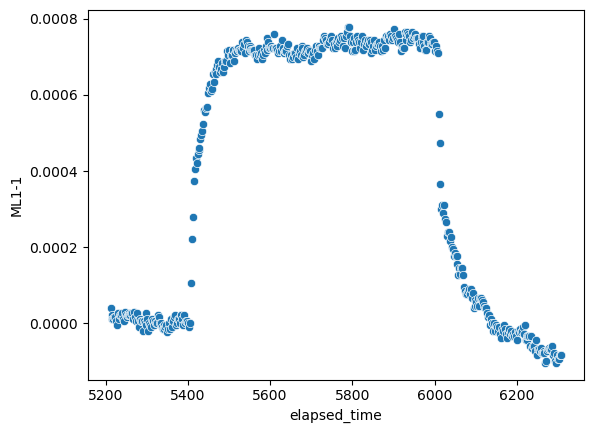

In [154]:
sns.scatterplot(data = cycles[2], x = 'elapsed_time', y = 'ML1-1')

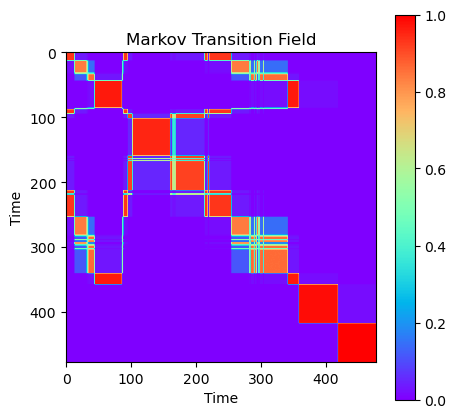

array([[0.93220339, 0.93220339, 0.93220339, ..., 0.        , 0.        ,
        0.        ],
       [0.93220339, 0.93220339, 0.93220339, ..., 0.        , 0.        ,
        0.        ],
       [0.93220339, 0.93220339, 0.93220339, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 1.        ,
        1.        ],
       [0.        , 0.        , 0.        , ..., 1.        , 1.        ,
        1.        ],
       [0.        , 0.        , 0.        , ..., 1.        , 1.        ,
        1.        ]])

In [112]:

cycle_subset = np.array(cycles[0]['ML1-1'].to_list())
draw_mtf(cycle_subset)

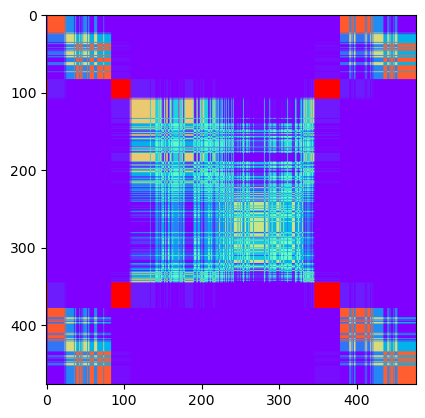

In [155]:
mtf = MarkovTransitionField()
cycle_subset = np.array(cycles[3]['ML1-1'].to_list())
# Transform the time series data into an MTF image
X_mtf = mtf.fit_transform(np.array(cycle_subset).reshape(1, -1))
convert_to_RGB(X_mtf[0], '')

In [140]:
def convert_to_RGB(array, name):
    
    # array normalization to be the range [0,1]
    arr_min = array.min()
    arr_max = array.max()
    # print(arr_min)
    # print(arr_max)
    if arr_min == arr_max:
        image = array
    else:
        image = (array - arr_min) / (arr_max - arr_min)
    plt.figure()
    cmap = plt.get_cmap('rainbow')
    image_colormap = cmap(image)
    image_rgb = (image_colormap[:,:,:3]*255).astype(np.uint8)
    image_pil = Image.fromarray(image_rgb)
    plt.imshow(image_pil)

    resized = image_pil.resize((128,128))

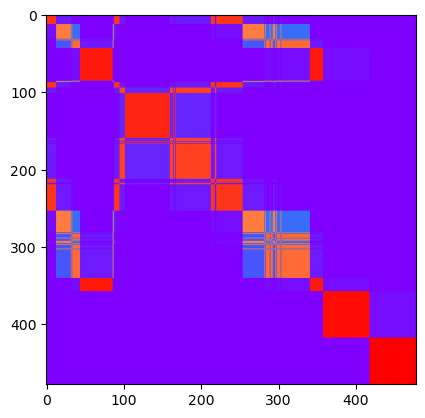

In [141]:
convert_to_RGB(X_mtf[0], '')

In [62]:
data_loc3 = sorted(directory.glob('20240717_*_processed.xlsx'))
data_loc3

[PosixPath('/home/hyang/Documents/activity_resistance_ML/processed/20240717_1-2_CO_25ppm_50_processed.xlsx')]

In [63]:
df3 = pd.read_excel(data_loc3[0], sheet_name = 'sensitivity')
df3.head()

,Unnamed: 0,Time,Elapsed,ML1-1,ML1-2,ML1-3,ML1-4,ML1-5,ML1-6,ML1-7,...,ML2-1,ML2-2,ML2-3,ML2-4,ML2-5,ML2-6,ML2-7,ML2-8,Timestamp,elapsed_time
0,0,7/17/2024 14:43:33:253,00:03:00:21:625,0.000049,0.000085,0.000070,0.000069,0.000083,0.000089,0.000090,...,0.000170,0.000168,0.000216,0.000239,0.000264,0.000280,0.000309,0,2024-07-17 14:43:33.253,3486.152
1,1,7/17/2024 14:43:38:940,00:03:00:27:312,0.000050,0.000089,0.000067,0.000079,0.000090,0.000101,0.000062,...,0.000162,0.000177,0.000208,0.000241,0.000269,0.000267,0.000312,0,2024-07-17 14:43:38.940,3491.839
2,2,7/17/2024 14:43:44:628,00:03:00:33:000,0.000049,0.000075,0.000069,0.000077,0.000096,0.000098,0.000059,...,0.000170,0.000188,0.000206,0.000224,0.000269,0.000285,0.000298,0,2024-07-17 14:43:44.628,3497.527
3,3,7/17/2024 14:43:50:315,00:03:00:38:687,0.000030,0.000088,0.000076,0.000067,0.000096,0.000120,0.000056,...,0.000170,0.000173,0.000227,0.000237,0.000259,0.000271,0.000301,0,2024-07-17 14:43:50.315,3503.214
4,4,7/17/2024 14:43:56:01,00:03:00:44:373,0.000049,0.000092,0.000069,0.000080,0.000084,0.000105,0.000055,...,0.000158,0.000166,0.000182,0.000221,0.000251,0.000286,0.000312,0,2024-07-17 14:43:56.010,3508.909


<Axes: xlabel='elapsed_time', ylabel='ML1-1'>

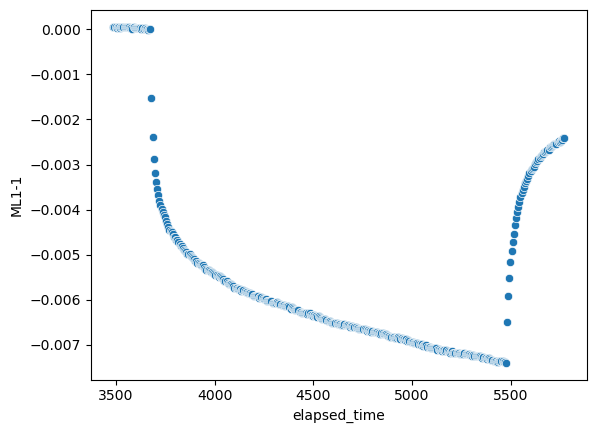

In [64]:
sns.scatterplot(data = df3, x = 'elapsed_time', y= 'ML1-1')

In [65]:
df3['time_diff'] = df3['elapsed_time'].diff()
large_diff_rows3 = df3[df3['time_diff'] > 10]
time_cut = large_diff_rows3['elapsed_time'].to_list()
len(time_cut)

0

In [7]:
# 
df['time_diff'] = df['elapsed_time'].diff()
large_diff_rows = df[df['time_diff'] > 10]
time_cut = large_diff_rows['elapsed_time'].to_list()
time_cut

[8806.304000000207, 10609.62899999978]

In [8]:

cycle1= df[df['elapsed_time'] < time_cut[0]]
cycle2 = df[(df['elapsed_time'] >= time_cut[0]) & (df['elapsed_time'] < time_cut[1])]
cycle3 = df[(df['elapsed_time'] > time_cut[1])]

cycles = [cycle1, cycle2, cycle3]

<Axes: xlabel='elapsed_time', ylabel='MLmx13-3'>

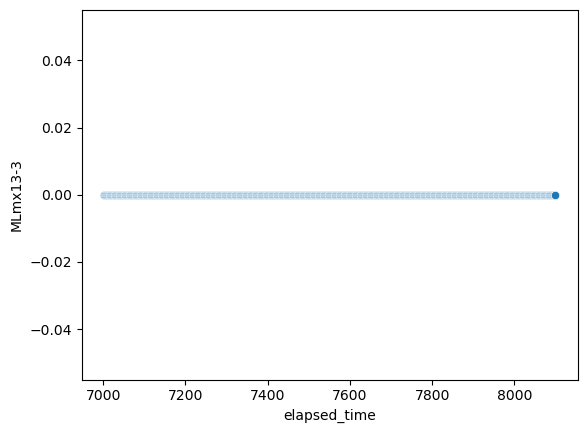

In [90]:
sns.scatterplot(data = cycle1, x = 'elapsed_time', y= 'MLmx13-3')

In [86]:
trial1 = np.array(cycle1['MLmx13-3'].to_list())
trial2 = np.array(cycle2['MLmx9-1'].to_list())
trial3 = np.array(cycle3['MLmx9-1'].to_list())

In [85]:
transform = MarkovTransitionField()
def apply_transform(column):
        column_data = column.values.reshape(1,-1)
        return transform.fit_transform(column_data)[0]
    

after_transformed_dict = {col: apply_transform(cycle1[col]) for col in cycle1.columns if 'ML' in col}
after_transformed_dict

/home/hyang/anaconda3/envs/py3.10/lib/python3.10/site-packages/pyts/preprocessing/discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
/home/hyang/anaconda3/envs/py3.10/lib/python3.10/site-packages/pyts/preprocessing/discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "


{'MLmx9-1': array([[0.76119403, 0.17910448, 0.17910448, ..., 0.        , 0.        ,
         0.        ],
        [0.16666667, 0.57575758, 0.57575758, ..., 0.25757576, 0.        ,
         0.        ],
        [0.16666667, 0.57575758, 0.57575758, ..., 0.25757576, 0.        ,
         0.        ],
        ...,
        [0.        , 0.23529412, 0.23529412, ..., 0.66176471, 0.10294118,
         0.10294118],
        [0.        , 0.        , 0.        , ..., 0.08955224, 0.91044776,
         0.91044776],
        [0.        , 0.        , 0.        , ..., 0.08955224, 0.91044776,
         0.91044776]]),
 'MLmx9-2': array([[0.6875    , 0.25      , 0.6875    , ..., 0.25      , 0.25      ,
         0.25      ],
        [0.2173913 , 0.60869565, 0.2173913 , ..., 0.60869565, 0.60869565,
         0.60869565],
        [0.6875    , 0.25      , 0.6875    , ..., 0.25      , 0.25      ,
         0.25      ],
        ...,
        [0.2173913 , 0.60869565, 0.2173913 , ..., 0.60869565, 0.60869565,
         0.6

In [13]:

len(cycle1['elapsed_time'])

538

In [14]:
# time = np.arange(0, len(elapsed_time)*2.9, 2.9)
# time[-1]

In [ ]:
print(len(time))
time.shape


In [ ]:
d = np.array(df['MLmx9-1'])
len(d)

In [37]:
print(len(d))
d.shape


1614


(1614,)

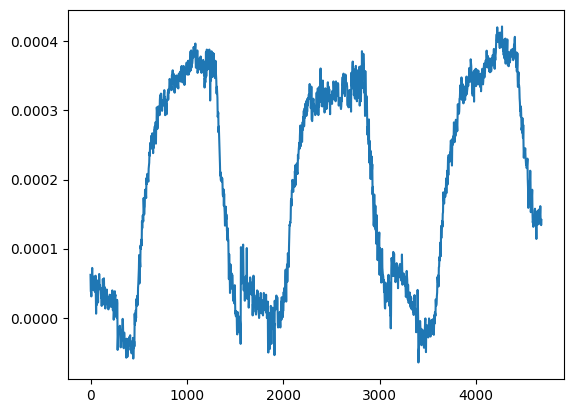

In [38]:
plt.plot(time, d)

## Recurrence Plot

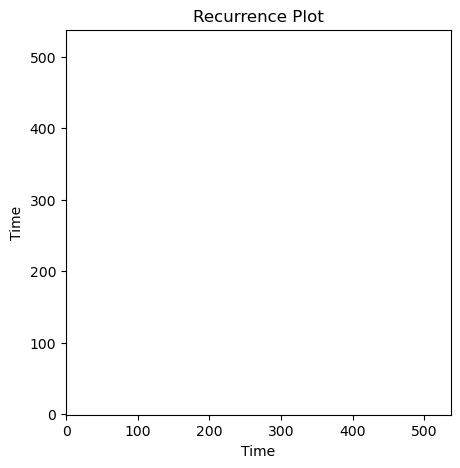

(1, 538, 538)

In [87]:
# Initialize RecurrencePlot
rp = RecurrencePlot()

# Transform the time series data into a recurrence plot
X_rp = rp.fit_transform(trial1.reshape(1, -1))

# Plot the recurrence plot
plt.figure(figsize=(5, 5))
plt.imshow(X_rp[0], cmap='binary', origin='lower')
plt.title('Recurrence Plot')
plt.xlabel('Time')
plt.ylabel('Time')
plt.show()
X_rp.shape

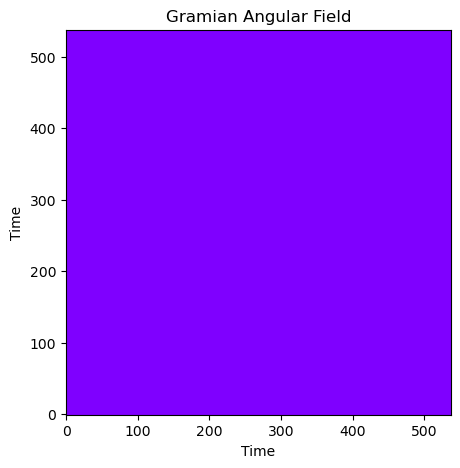

(1, 538, 538)

In [88]:
gaf = GramianAngularField(method = 'summation')
X_ml1 = gaf.fit_transform(trial1.reshape(1, -1))
plt.figure(figsize=(5, 5))
plt.imshow(X_ml1[0], cmap='rainbow', origin='lower')
plt.title('Gramian Angular Field')
plt.xlabel('Time')
plt.ylabel('Time')
plt.show()
X_ml1.shape

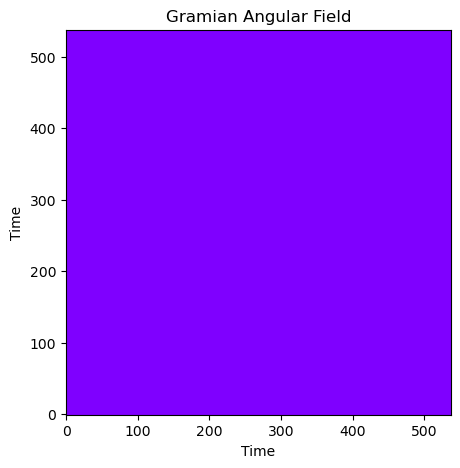

(1, 538, 538)

In [89]:
gaf = GramianAngularField(method = 'difference')
X_ml1 = gaf.fit_transform(trial1.reshape(1, -1))
plt.figure(figsize=(5, 5))
plt.imshow(X_ml1[0], cmap='rainbow', origin='lower')
plt.title('Gramian Angular Field')
plt.xlabel('Time')
plt.ylabel('Time')
plt.show()
X_ml1.shape

In [39]:
def draw_mtf(data):
    mtf = MarkovTransitionField()
    
    # Transform the time series data into an MTF image
    X_mtf = mtf.fit_transform(np.array(data).reshape(1, -1))
    
    # Plot the MTF image
    plt.figure(figsize=(5, 5))
    plt.imshow(X_mtf[0], cmap='rainbow', origin='upper')
    plt.title('Markov Transition Field')
    plt.xlabel('Time')
    plt.ylabel('Time')
    plt.colorbar()
    plt.show()
    return X_mtf[0]

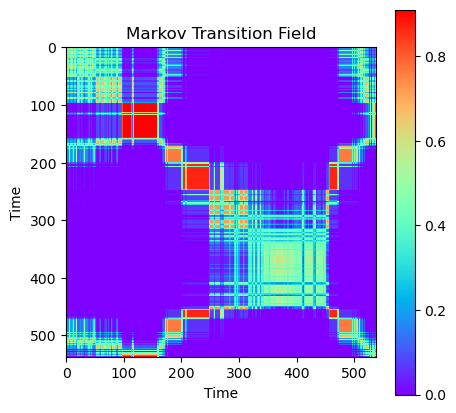

array([[0.76119403, 0.17910448, 0.17910448, ..., 0.        , 0.        ,
        0.        ],
       [0.16666667, 0.57575758, 0.57575758, ..., 0.25757576, 0.        ,
        0.        ],
       [0.16666667, 0.57575758, 0.57575758, ..., 0.25757576, 0.        ,
        0.        ],
       ...,
       [0.        , 0.23529412, 0.23529412, ..., 0.66176471, 0.10294118,
        0.10294118],
       [0.        , 0.        , 0.        , ..., 0.08955224, 0.91044776,
        0.91044776],
       [0.        , 0.        , 0.        , ..., 0.08955224, 0.91044776,
        0.91044776]])

In [40]:
draw_mtf(trial1)

In [22]:
X_ml1.shape

(1, 538, 538)

In [23]:
X_ml1[0].shape

(538, 538)

In [35]:
X_ml1[0].min()

-0.9999999995080908

In [47]:
# convert image to RGB

from PIL import Image

def convert_to_RGB(array, name):
    if array.min() < 0:
        image = (array+1)/2
    else:
        image = array
    cmap = plt.get_cmap('rainbow')
    image_colormap = cmap(image)
    image_rgb = (image_colormap[:,:,:3]*255).astype(np.uint8)
    image_pil = Image.fromarray(image_rgb)

    resized = image_pil.resize((128,128))
    resized.save(name+'.jpg')



In [48]:
convert_to_RGB(X_ml1[0], 'GAF')

In [52]:
gaf = GramianAngularField(method = 'difference')
X_ml1_c2 = gaf.fit_transform(trial2.reshape(1, -1))
X_ml1_c3 = gaf.fit_transform(trial3.reshape(1, -1))
convert_to_RGB(X_ml1_c2[0], 'GAF_c2')
convert_to_RGB(X_ml1_c3[0], 'GAF_c3')

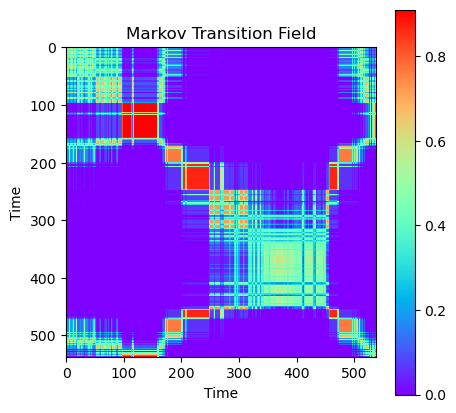

In [49]:
d = draw_mtf(trial1)
convert_to_RGB(d, 'MTF')

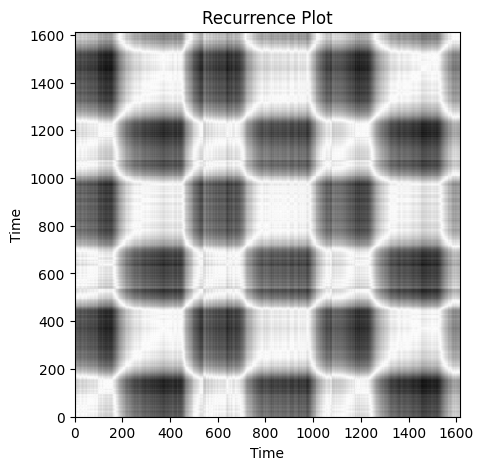

(1, 1614, 1614)

In [46]:
# Initialize RecurrencePlot
rp = RecurrencePlot()

# Transform the time series data into a recurrence plot
X_rp = rp.fit_transform(d.reshape(1, -1))

# Plot the recurrence plot
plt.figure(figsize=(5, 5))
plt.imshow(X_rp[0], cmap='binary', origin='lower')
plt.title('Recurrence Plot')
plt.xlabel('Time')
plt.ylabel('Time')
plt.show()
X_rp.shape

<Axes: xlabel='elapsed_time', ylabel='MLmx9-1'>

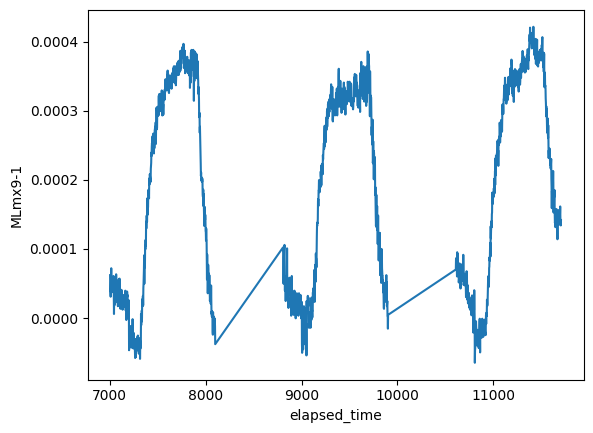

In [48]:
sns.lineplot(data = df, x = 'elapsed_time', y = 'MLmx9-1')

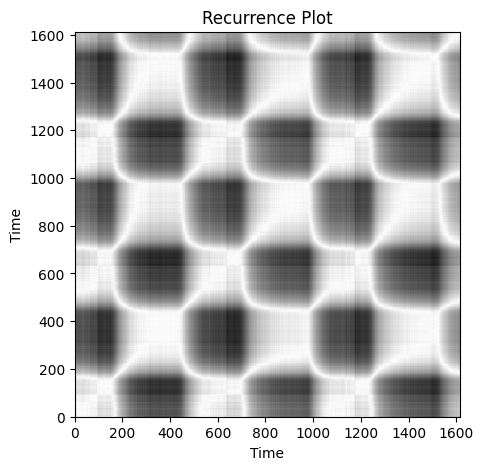

(1, 1614, 1614)

In [52]:
rp = RecurrencePlot()
X_ml2 = rp.fit_transform(np.array(df['MLmx9-5']).reshape(1, -1))
plt.figure(figsize=(5, 5))
plt.imshow(X_ml2[0], cmap='binary', origin='lower')
plt.title('Recurrence Plot')
plt.xlabel('Time')
plt.ylabel('Time')
plt.show()
X_ml2.shape

<Axes: xlabel='elapsed_time', ylabel='MLmx9-5'>

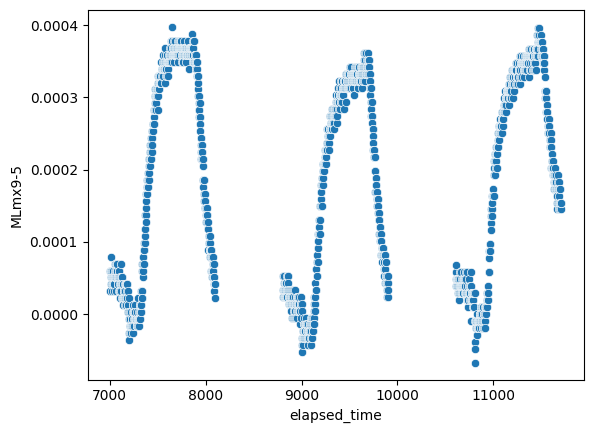

In [71]:
sns.scatterplot(data = df, x = 'elapsed_time', y = 'MLmx9-5')

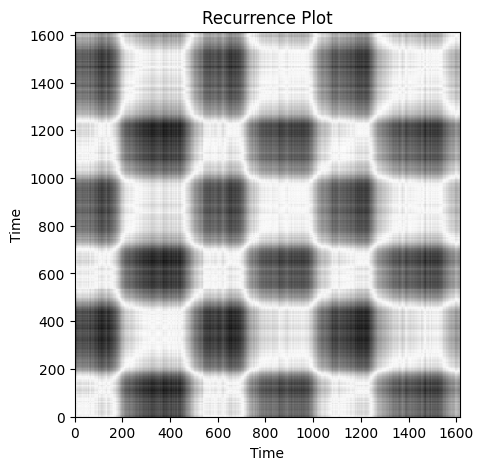

(1, 1614, 1614)

In [53]:
rp = RecurrencePlot()
X_ml10 = rp.fit_transform(np.array(df['MLmx9-6']).reshape(1, -1))
plt.figure(figsize=(5, 5))
plt.imshow(X_ml10[0], cmap='binary', origin='lower')
plt.title('Recurrence Plot')
plt.xlabel('Time')
plt.ylabel('Time')
plt.show()
X_ml10.shape

<Axes: xlabel='elapsed_time', ylabel='MLmx9-6'>

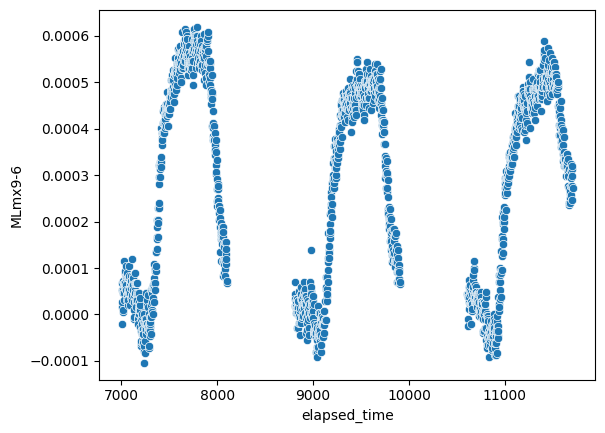

In [72]:
sns.scatterplot(data = df, x = 'elapsed_time', y = 'MLmx9-6')

## Granmian Angular Field

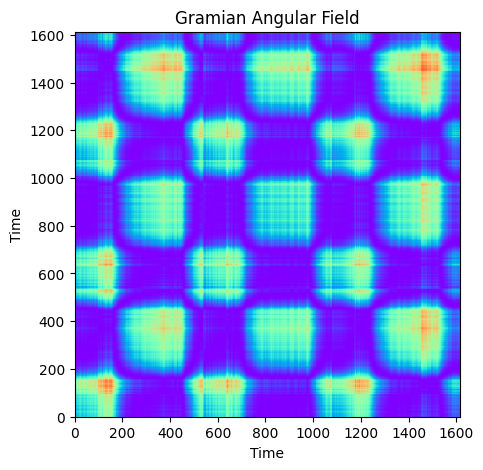

(1, 1614, 1614)

In [56]:
gaf = GramianAngularField(method = 'summation')
X_ml1 = gaf.fit_transform(np.array(df['MLmx9-1']).reshape(1, -1))
plt.figure(figsize=(5, 5))
plt.imshow(X_ml1[0], cmap='rainbow', origin='lower')
plt.title('Gramian Angular Field')
plt.xlabel('Time')
plt.ylabel('Time')
plt.show()
X_ml1.shape

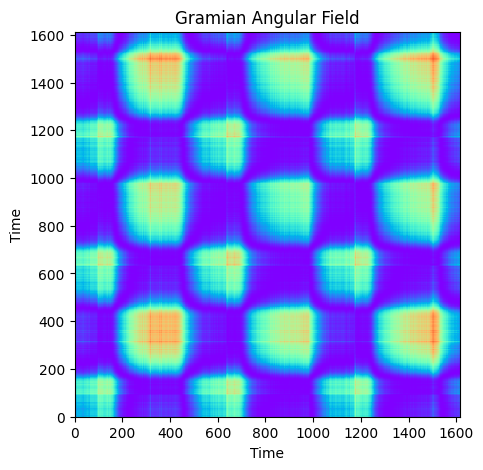

(1, 1614, 1614)

In [57]:
gaf = GramianAngularField(method = 'summation')
X_ml2 = gaf.fit_transform(np.array(df['MLmx9-5']).reshape(1, -1))
plt.figure(figsize=(5, 5))
plt.imshow(X_ml2[0], cmap='rainbow', origin='lower')
plt.title('Gramian Angular Field')
plt.xlabel('Time')
plt.ylabel('Time')
plt.show()
X_ml2.shape

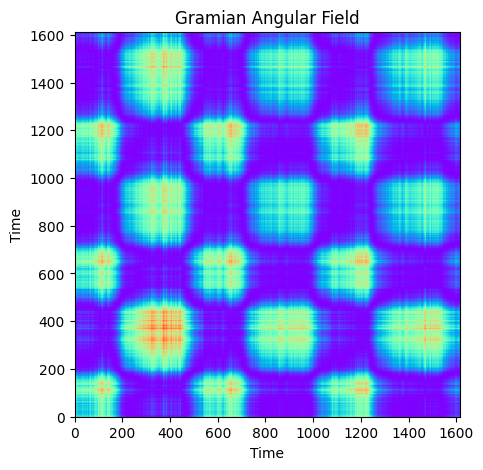

In [78]:
gaf = GramianAngularField(method = 'summation')
X_ml10 = gaf.fit_transform(np.array(df['MLmx9-6']).reshape(1, -1))
plt.figure(figsize=(5, 5))
plt.imshow(X_ml10[0], cmap='rainbow', origin='lower')
plt.title('Gramian Angular Field')
plt.xlabel('Time')
plt.ylabel('Time')
plt.show()

## Difference with Gramian augnlar Difference


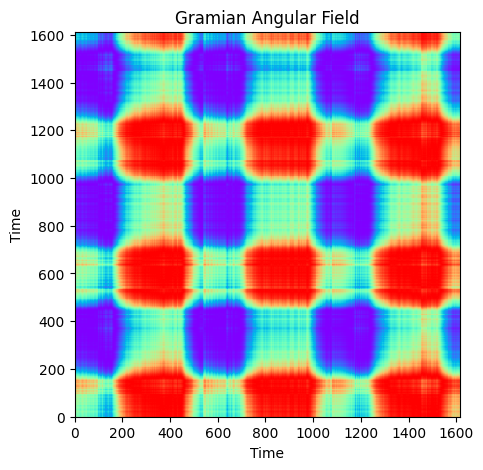

(1, 1614, 1614)

In [60]:
gaf = GramianAngularField(method = 'difference')
X_ml1 = gaf.fit_transform(np.array(df['MLmx9-1']).reshape(1, -1))
plt.figure(figsize=(5, 5))
plt.imshow(X_ml1[0],'rainbow', origin='lower')
plt.title('Gramian Angular Field')
plt.xlabel('Time')
plt.ylabel('Time')
plt.show()
X_ml1.shape

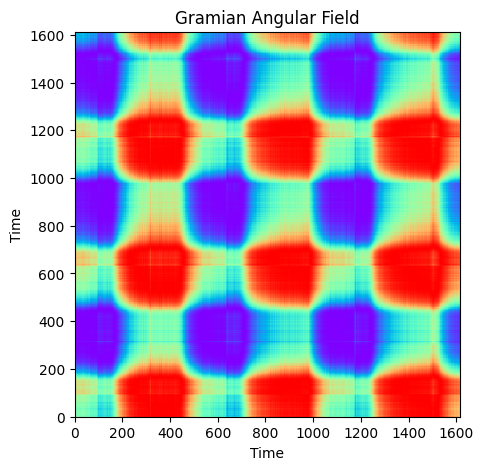

(1, 1614, 1614)

In [61]:
gaf = GramianAngularField(method = 'difference')
X_ml2 = gaf.fit_transform(np.array(df['MLmx9-5']).reshape(1, -1))
plt.figure(figsize=(5, 5))
plt.imshow(X_ml2[0], cmap='rainbow', origin='lower')
plt.title('Gramian Angular Field')
plt.xlabel('Time')
plt.ylabel('Time')
plt.show()
X_ml2.shape

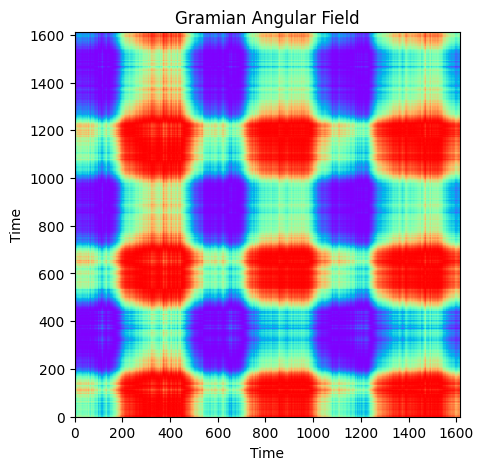

(1, 1614, 1614)

In [62]:
gaf = GramianAngularField(method = 'difference')
X_ml10 = gaf.fit_transform(np.array(df['MLmx9-6']).reshape(1, -1))
plt.figure(figsize=(5, 5))
plt.imshow(X_ml10[0], cmap='rainbow', origin='lower')
plt.title('Gramian Angular Field')
plt.xlabel('Time')
plt.ylabel('Time')
plt.show()
X_ml10.shape

## Markov Transition Field

In [23]:
def draw_mtf(data):
    mtf = MarkovTransitionField()
    
    # Transform the time series data into an MTF image
    X_mtf = mtf.fit_transform(np.array(data).reshape(1, -1))
    
    # Plot the MTF image
    plt.figure(figsize=(5, 5))
    plt.imshow(X_mtf[0], cmap='rainbow', origin='lower')
    plt.title('Markov Transition Field')
    plt.xlabel('Time')
    plt.ylabel('Time')
    plt.colorbar()
    plt.show()

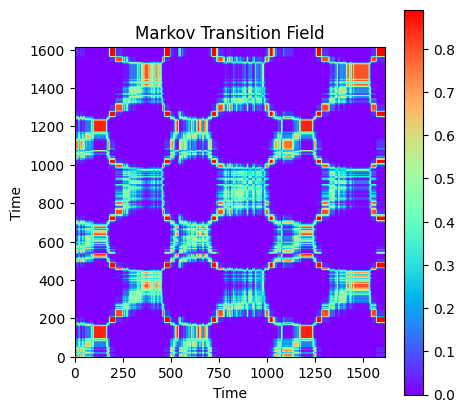

In [66]:
draw_mtf(df['MLmx9-1'])

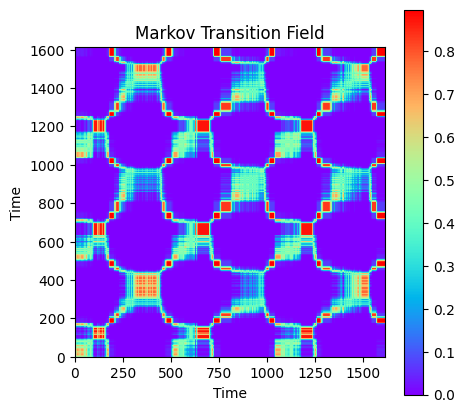

In [67]:
draw_mtf(df['MLmx9-5'])

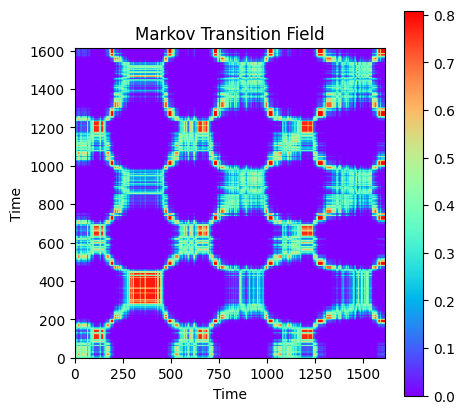

In [69]:
draw_mtf(df['MLmx9-6'])